In [2]:
import cv2                                # state of the art computer vision algorithms library
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library producing publication quality figures
import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
import time
import open3d as o3d
import  multiprocessing as mp
print("Environment Ready")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Environment Ready


In [142]:
PATH = 'Data/'
NAME = 'G3_R_6-8_with_f_near2_no_df'#'capsicum2_tf1'#'tomato1'
res_x, res_y = 1280, 720 # 640, 480
HOLE_FILLING = False

pipe = rs.pipeline()
cfg = rs.config()

cfg.enable_stream(rs.stream.depth, res_x, res_y, rs.format.z16, 30) #1280*720  640*480
cfg.enable_stream(rs.stream.color, res_x, res_y, rs.format.rgb8, 30)
profile = pipe.start(cfg)

# Getting the depth sensor's depth scale (see rs-align example for explanation)
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()

Frames Captured
(720, 1280, 3)


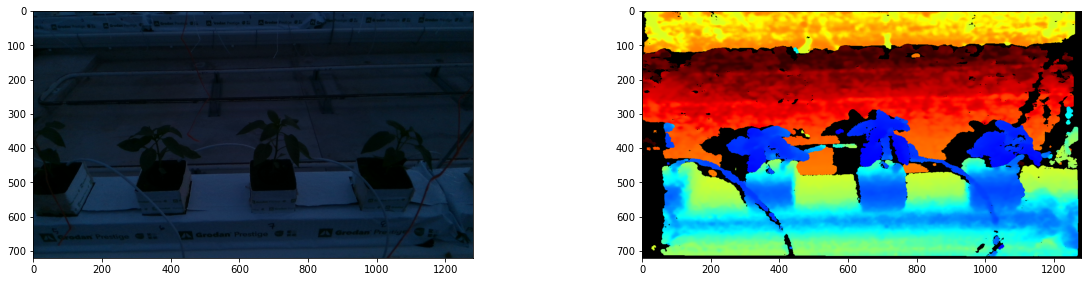

In [143]:



align_to = rs.stream.color
align = rs.align(align_to)

for x in range(5):
    pipe.wait_for_frames()
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()

aligned_frames = align.process(frameset)

depth_frame = aligned_frames.get_depth_frame()
color_frame = aligned_frames.get_color_frame()


# Cleanup:
pipe.stop()
print("Frames Captured")

colorizer = rs.colorizer()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
print(colorized_depth.shape)
#plt.imshow(colorized_depth)
# plt.imshow(color_frame.get_data())
images = [color_frame.get_data(), colorized_depth]

plt.figure(figsize=(20,10))
columns = 2
for i, image in enumerate(images):
    plt.subplot(len(images) // columns + 1, columns, i + 1)
    plt.imshow(image)

(720, 1280)


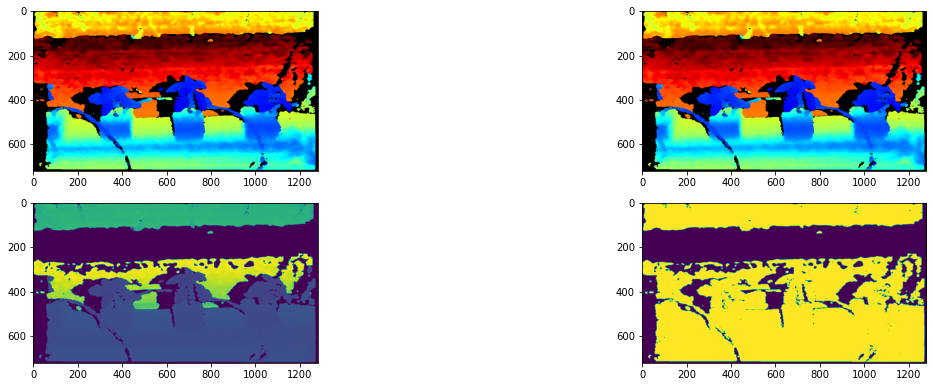

In [144]:
HOLE_FILLING = False
DECIMATION =  False
DEPTH_TO_DISPARITY = True
SPARTIAL = True
TEMPORAL = True
DISPARITY_TO_DEPTH = True


DEPTH_FILTERING = True
clipping_distance_min =  0.3 / depth_scale
clipping_distance_max = 3 / depth_scale


# ===== Filtering ==========
# https://github.com/IntelRealSense/librealsense/blob/jupyter/notebooks/depth_filters.ipynb
#https://dev.intelrealsense.com/docs/post-processing-filters

depth_frame0 = depth_frame



disparity_to_depth = rs.disparity_transform(False)
decimation = rs.decimation_filter()
spatial = rs.spatial_filter()
temporal = rs.temporal_filter()
hole_filling = rs.hole_filling_filter()

if DECIMATION:
   depth_frame = decimation.process(depth_frame)
if DEPTH_TO_DISPARITY:
    depth_frame = depth_to_disparity.process(depth_frame)
if SPARTIAL:
    depth_frame = spatial.process(depth_frame)
if TEMPORAL:
    depth_frame = temporal.process(depth_frame)
if DISPARITY_TO_DEPTH:
    depth_frame = disparity_to_depth.process(depth_frame)
if HOLE_FILLING:
    depth_frame = hole_filling.process(depth_frame)

#================================

depth_data0 = np.asanyarray(depth_frame.get_data())
color_data = np.asanyarray(color_frame.get_data())

print(depth_data0.shape)
res_y = depth_data0.shape[0]
res_x = depth_data0.shape[1]

pc = rs.pointcloud()
pc.map_to(color_frame)

points = pc.calculate(depth_frame)
verts =  np.asanyarray(points.get_vertices())
verts = verts.view(np.float32).reshape(res_y, res_x, 3) #ToDo: save as NPY for later use

if DEPTH_FILTERING:
    depth_data = np.where((depth_data0 > clipping_distance_max) , 0, depth_data0)
    depth_data = np.where((depth_data <= clipping_distance_min) , 0, depth_data)

    dr = np.where((depth_data > 0) , 1, 0)

    depth_image_3d = np.dstack((dr,dr,dr))

    verts = np.where((depth_image_3d > 0) , verts, 0)
    

colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
colorized_depth0 = np.asanyarray(colorizer.colorize(depth_frame0).get_data())

images = [colorized_depth0, colorized_depth, depth_data, dr]

plt.figure(figsize=(20,10))
columns = 2
for i, image in enumerate(images):
    plt.subplot(len(images) // columns + 1, columns, i + 1)
    plt.imshow(image)

In [145]:

#res_x, res_y = 640, 480

pc = rs.pointcloud()
pc.map_to(color_frame)

# xmin, xmax, ymin, ymax = 0, 1280, 0, 720 # BB
# #xmin, xmax, ymin, ymax = 200, 1000, 200, 720 # BB
# #xmin, xmax, ymin, ymax = 400, 1000, 200, 600 # 1.5

# #r = np.zeros([720, 1280])

# offset = 1
# verts = verts[ymin:ymax:offset, xmin:xmax:offset, :]
# dr = dr[ymin:ymax:offset, xmin:xmax:offset]

# plt.imshow(dr)
# plt.imshow(verts)

# pcd = o3d.geometry.PointCloud()
# res_x1 = int((xmax-xmin)/offset)
# res_y1 =  int((ymax-ymin)/offset)


pcd.points = o3d.utility.Vector3dVector(verts.reshape(res_x*res_y,3))
o3d.visualization.draw_geometries([pcd])
if HOLE_FILLING:
    HF='_hf1'
else:
    HF='_hf0'
np.save(PATH + NAME+ HF+'_verts.npy', verts)
np.save(PATH + NAME+ HF+'_depth.npy', depth_data)
np.save(PATH + NAME+ HF+'_color.npy', color_data)
print("Done")
print(verts.shape)
print(dr.shape)

Done
(720, 1280, 3)
(720, 1280)


In [4]:
# a=np.array([[1,2,3],[4,5,6],[7,8,9]])
# b=np.array([[1,1,1],[1,1,1],[1,1,1]])
# print(math.cos(30))
# a-b*math.cos(30)

import math

I = False
h = []

for i in range(1280):
    v = (i/ 1280) * (2.0/depth_scale) 
    row = np.full((1, 720), v)
    if not I:
        h=np.array(row)
        I=True
    else:
        h=np.vstack([h, row])
    #break
    #np.insert(h, i, row,0)
#h=np.asarray(h)
h=h.T
h.shape

(720, 1280)

 ## loading saved data for process

d_data (720, 1280)
verts_ (720, 1280, 3)
Verts (144, 256, 3)
dr (144, 256)


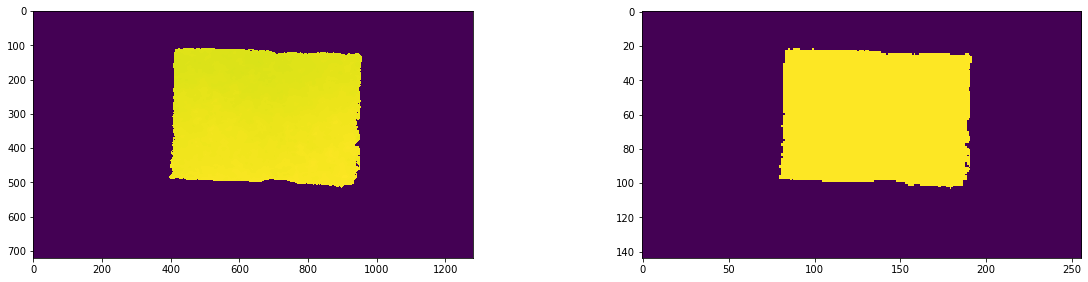

In [158]:


PATH = 'Data/'
#res_x, res_y = 1280, 720  #0.5m or 1m
#res_x, res_y = 600, 400 # 1m 
#res_x, res_y = 130, 200
HOLE_FILLING= False
if HOLE_FILLING:
    HF='_hf1'
else:
    HF='_hf0'


NAME = 'A40.5_9'
#NAME = 'A41_0'

#clipping_distance_min =  0 / depth_scale
#clipping_distance_max = 4 / depth_scale

verts_ = np.load(PATH + NAME+HF+'_verts.npy')
depth_data_ = np.load(PATH + NAME+HF+'_depth.npy')
color_data_ = np.load(PATH + NAME+HF+'_color.npy')

print("d_data",depth_data_.shape)
print("verts_",verts_.shape)
#plt.imshow(depth_data_)

#depth_data_ = depth_data_- h*math.cos(30)

#depth_data = np.where((depth_data_ > clipping_distance_max) , 0, depth_data_)
#depth_data = np.where((depth_data_ <= clipping_distance_min) , 0, depth_data)


#--- if depth res is 720, 1280 for 1m---
offset = 5
#xmin, xmax, ymin, ymax = 200, 1000, 100, 600 #.5m, 1m
xmin, xmax, ymin, ymax = 0, 1280, 0, 720 #.5m
#xmin, xmax, ymin, ymax = 400, 1000, 200, 600  # 1m

# # #---1m, 1.5 from sample 2 special case : d_data 1280x720, vertex 600x400 -----
# xmin, xmax, ymin, ymax = 400, 1000, 200, 600  # 1m
# depth_data_ = depth_data_[ymin:ymax, xmin:xmax]
# xmin, xmax, ymin, ymax = 0, 600, 0, 400


verts_ = verts_[ymin:ymax:offset, xmin:xmax:offset, :]
res_x = int((xmax-xmin)/offset)
res_y = int((ymax-ymin)/offset)

dr = np.where((depth_data_ > 0) , 1, 0)
dr = dr[ymin:ymax:offset, xmin:xmax:offset]


#dr = dr[ymin:ymax, xmin:xmax]
#depth_image_3d = np.dstack((dr,dr,dr))
#verts = np.where((depth_image_3d > 0) , verts_, 0)


print("Verts",verts_.shape)
print("dr",dr.shape)
#plt.imshow(depth_data)
#plt.imshow(depth_data_)
pcd1 = o3d.geometry.PointCloud()
pcd1.points = o3d.utility.Vector3dVector(verts_.reshape(res_x*res_y,3))
o3d.visualization.draw_geometries([pcd1])

images = [depth_data_, dr]

plt.figure(figsize=(20,10))
columns = 2
for i, image in enumerate(images):
    plt.subplot(len(images) // columns + 1, columns, i + 1)
    plt.imshow(image, interpolation='nearest')

In [159]:
number_of_processes = 8

def findTri(nv, trs):
    while len(nv)>0:
        p=nv.__getitem__(0)

        i=p[0]
        j=p[1]
        nv.remove(p)
        try:
            if i-1 >= 0 and j-1 >= 0 and pts[i-1][j-1]>0:
                nv.remove([i-1,j-1]) if [i-1, j-1] in nv else None
                if pts[i-1][j]>0:
                    trs.append([[i-1,j-1],[i-1, j], p])
                    nv.remove([i-1, j]) if [i-1, j] in nv else None
                if pts[i][j-1]>0:
                    trs.append([[i-1,j-1],[i, j-1], p])
                    nv.remove([i, j-1]) if [i, j-1] in nv else None
            if i-1 >= 0 and j+1 < pts.shape[1] and pts[i-1][j+1]>0:
                nv.remove([i-1,j+1]) if [i-1, j+1] in nv else None
                if pts[i-1][j]>0:
                    trs.append([[i-1, j],[i-1,j+1], p])
                    nv.remove([i-1, j]) if [i-1, j] in nv else None
                if pts[i][j+1]>0:
                    trs.append([[i-1, j+1], p, [i,j+1]])
                    nv.remove([i, j+1]) if [i, j+1] in nv else None
            if i+1 < pts.shape[0] and j+1 < pts.shape[1] and pts[i+1][j+1]>0:
                nv.remove([i+1,j+1]) if [i+1, j+1] in nv else None
                if pts[i+1][j]>0:
                    trs.append([p,[i+1, j],[i+1,j+1]])
                    nv.remove([i+1,j]) if [i+1, j] in nv else None
                if pts[i][j+1]>0:
                    trs.append([p, [i,j+1], [i+1, j+1]])
                    nv.remove([i, j+1]) if [i, j+1] in nv else None
            if i+1 < pts.shape[0] and j-1 >= 0 and pts[i+1][j-1]>0:
                nv.remove([i+1,j-1]) if [i+1, j-1] in nv else None
                if pts[i+1][j]>0:
                    trs.append([p,[i+1, j],[i+1,j-1]])
                    nv.remove([i+1,j]) if [i+1, j] in nv else None
                if pts[i][j-1]>0:
                    trs.append([p, [i,j-1], [i+1, j-1]])
                    nv.remove([i, j-1]) if [i, j-1] in nv else None
        except:
            continue
    return trs


def callback(result):
    print(len(trs))
    print(trs[0])
    print("timetaken: ", str(time.time()-t1))
    pool.close()
    pool.join()

pts = np.array(dr) #ps3
#trs=[]
r = np.argwhere(pts>0)
print(len(r))
#nv = r.tolist()
man = mp.Manager()
pool = mp.Pool(processes = number_of_processes)
nv = man.list(r.tolist())
trs = man.list()
t1= time.time()

print(len(nv))

pool.apply_async(findTri, (nv,trs), callback=callback)

8264
8264


15954
[[22, 85], [23, 85], [23, 86]]
timetaken:  2.5497219562530518


In [160]:
def heron(a,b,c):  
    s = (a + b + c) / 2   
    area = (s*(s-a)*(s-b)*(s-c)) ** 0.5        
    return area

def distance3d(x1,y1,z1,x2,y2,z2):    
    a=(x1-x2)**2+(y1-y2)**2 + (z1-z2)**2
    d= a ** 0.5  
    return d  

def areatriangle3d(p1, p2, p3):  
    a=distance3d(p1[0],p1[1],p1[2],p2[0],p2[1],p2[2])  
    b=distance3d(p2[0],p2[1],p2[2],p3[0],p3[1],p3[2])  
    c=distance3d(p3[0],p3[1],p3[2],p1[0],p1[1],p1[2])  
    A = heron(a,b,c)  
    return A


pool.terminate
pool.close()
t1= time.time()
area = 0
print("# Trs: ", str(len(trs)))
for t in trs:
    p1=verts_[t[0][0], t[0][1]]
    p2=verts_[t[1][0], t[1][1]]
    p3=verts_[t[2][0], t[2][1]]
    area= area+ areatriangle3d(p1, p2, p3)
    #print(view_obj[t[0][0], t[0][1]])
    #break
print("timetaken: ", str(time.time()-t1))

area = area*1000000

print(area, "mm2")
error =  (area - 62370)*100/ 62370
print("error", error)
      


# ------------ volume _---------
# K = 22/7
# area = area*10000
# print(str(area)," cm2")
# area = area*K
# print(str(area)," cm2")
# radius = np.power((area*7/88), 0.5)
# print(radius)
# print( "volume: ", str(area*radius/3), "ml" )

# error = abs(area - 623.70)*100/623.70
# print("error: ", str(error))

# Trs:  15954
timetaken:  0.8289897441864014
65816.80133047678 mm2
error 5.526376992908099


In [9]:
pool.terminate
pool.close()

(720, 1280, 3)
(720, 1280)


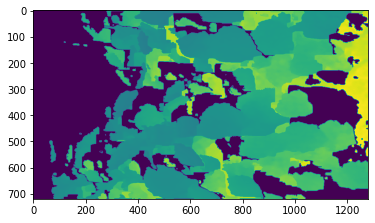

In [26]:
NAME = 'capsicum_42'
clipping_distance_min =  0.3 / depth_scale
clipping_distance_max = 1.3 / depth_scale

verts_ = np.load(PATH + NAME+'_verts.npy')
depth_data_ = np.load(PATH + NAME+'_depth_data.npy')

depth_data_1 = depth_data_- h*math.cos(30)

depth_data = np.where((depth_data_1 > clipping_distance_max) , 0, depth_data_)
depth_data = np.where((depth_data_1 <= clipping_distance_min) , 0, depth_data)

depth_image_3d = np.dstack((depth_data_,depth_data_,depth_data_))

verts = np.where((depth_image_3d > clipping_distance_max) , 0, verts_)
verts = np.where((depth_image_3d <= clipping_distance_min) , 0, verts)

print(verts.shape)
print(depth_data.shape)
plt.imshow(depth_data)
pcd1 = o3d.geometry.PointCloud()
pcd1.points = o3d.utility.Vector3dVector(verts.reshape(res_x*res_y,3))
#o3d.visualization.draw_geometries([pcd1])


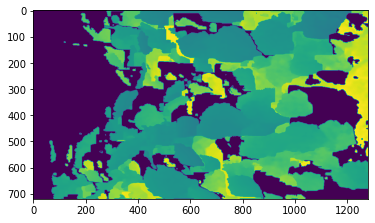

In [13]:
clipping_distance_min =  0.3 / depth_scale
clipping_distance_max = 1.3 / depth_scale
depth_data = np.where((depth_data_1 > clipping_distance_max) , 0, depth_data_1)
depth_data = np.where((depth_data_1 <= clipping_distance_min) , 0, depth_data)
plt.imshow(depth_data)

